# Tutoriel sur Pyroomacoustics

Ce document utilise un example simple pour propager une onde acoustique dans le package _pyroomacoustics_. Vous verez comment concevoir une pièce en plus de voir certains extrants de base du logiciel.

## Théorie

### Le son

L'acoustique se propage est comme une onde de pression. Lorsqu'un point source est utilisée, la pression sonore instantanée $p$ à une distance $R$ de la source est donnée par:

\begin{equation}
p(\omega, R) = \frac{exp\bigg(i\omega(R/c - t)\bigg)}{4\pi R}
\end{equation}

où $\omega$ est la fréquence de l'onde $2\pi f$, $t$ le temps et $c$.

Lorsque plusieurs sources sont utilisées, la pression calculée de différents point est simplement sommée à la source. C'est également le cas pour une onde réfléchie sur un mur.

Pour la mesure du niveau sonore, on peut s'intéressé à la pression acoustique efficace. Pour la calculer, on utilise le fait que la puissance acoustique est proportionelle au carré de la pression. La pression acoustique efficace est donnée par

\begin{equation}
p_{eff} = \sqrt{\frac{1}{t_i}\int_{t-t_i}^{t} p^2(t)dt}
\end{equation}

où $t_i$ est le temps d'intégration sur laquelle la mesure est prise. D'ailleurs, les instruments de mesure du son utilisent des circuits intégrateurs permettant de varier $t_i$ pour obtenir plus de precision sur une mesure.

Finalement, comme l'oreille humaine est capable de détecter des sons allant de quelques micropascals à plusieurs dizanes de pascals, le niveau sonore est souvent donné sous une échelle logarithmique (en __dB__). Elle est obtenue à l'aide du carré de la pression acoustique efficace.

\begin{equation}
N = 20\cdot \log_{10}\bigg(\frac{p_{eff}}{p_{ref}}\bigg)
\end{equation}

où $p_{ref} = 20 \rm{\mu Pa}$. Cependant, pour avoir le niveau sonore, il faut obtenir la pression acoustique instantanée et c'est pourquoi le logiciel de simulation est là.

## Utilisation de Pyroomacoustics

In [6]:
# importer les packages nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pyroomacoustics as pra
import IPython

# Je commence par définir un fichier à lire (qui est dans le dossier du code) qui donne deux informations:
# le signal et la fréquence d'échantillonage. C'est notre fichier d'entrée.
fs, signal = wavfile.read("scarface_say_hello.wav")
IPython.display.display(IPython.display.Audio(signal, rate=fs))

# IPython permet d'entendre l'extrait tirée du personnage de Tony Montana dans le film Scarface.

*Note: pour une raison que j'ignore, github empêche de lire les fichiers audio. Vous pouvez suivre la démonstration en faisant des copier/coller des partie de code dans un éditeur de Python ou vous pouvez aussi ouvrir le fichier _demonstration.ipynb_ sur Jupyter Notebook.

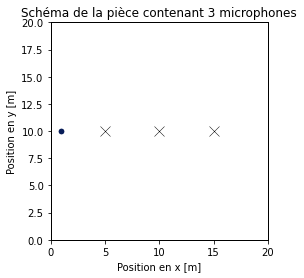

In [7]:
# Merci Al Pacino. On voudrait maintenant savoir ce que les auditeurs de Tony Montana entendaient.

# Définir la pièce. Pour faire le cas le plus simple possible, voici la pièce dans laquelle l'example est faite. 
# Les murs de cette pièce absorbent 10% du son. Une liste de matériaux avec leurs coefficients sont disponibles 
# sur le git de pyroomacoustics dans le fichier: pyroomacoustics/docs/pyroomacoustics.materials.database.rst

size = [20, 20]


wall_absorption = 0.1
wall_scattering = 0.1
props = [wall_absorption, wall_scattering]

# On peut definir les matériaux de chaque mur. Les plafonds et le plancher aussi dans le cas d'une pièce en 3D.
m = pra.make_materials(
    east=props,
    west=props,
    north=props,
    south=props
    )

# ShoeBox fait une pièce carrée. Il est possible d'en faire de toutes sortes de formes en utilisant des coordonnées de coins.
room = pra.ShoeBox(size, materials=m, fs=fs, max_order=10, air_absorption=True, ray_tracing=True)

# Ajouter une source et un microphone
X_source = [1, 10]
room.add_source(X_source, signal=signal)
X_micro = np.array([[5, 10, 15], [10, 10, 10]])  # [[x], [y], [z]]
room.add_microphone(X_micro)

# trace un schema de la situation
fig, ax = room.plot(mic_marker_size=100)
plt.title('Schéma de la pièce contenant 3 microphones');
plt.xlabel('Position en x [m]');
plt.ylabel('Position en y [m]');

In [8]:
# On souhaite maintenant mesurer ce qu'entendaient les auditeurs de Tony Montana. 
# pour ce faire on peut simplement utiliser la fonction simulate.
room.simulate()

# Les auditeurs entendent ce signal.
for i in range(3):
    IPython.display.display(IPython.display.Audio(room.mic_array.signals[i,:], rate=fs))

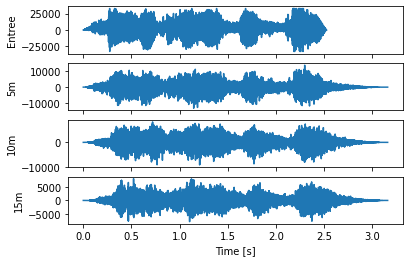

In [9]:
# Remarquez que le signal est plus long pour les auditeurs.
# En effet, les reverberations et le temps de propagation du son sont pris en compte.
# Voici la pression de l'air aux différents points.


# plot signal at microphone 1
fig, ax = plt.subplots(4, 1, sharex=True)
dt = 1/fs # pas de temps dans le signal

for i in range(4):
    if i == 0:
        sig = signal
        label = 'Entree' 
    else:
        sig = room.mic_array.signals[i-1,:]
        label = '%0.0dm' %(i*5) 
     
    time = np.linspace(0, dt*(len(sig)), len(sig))
    ax[i].plot(time, sig);
    ax[i].set_ylabel(label);
ax[3].set_xlabel('Time [s]');

## La réponse impulsionnelle

Ce que le logiciel fait pour permettre de calcul de la presion de sortie est qu'il calcule la réponse impulsionelle entre la source et le microphone. En effet, la réponse impulsionelle est la fonction de transfert qui permet, en __convoluant__ celle-ci avec une entrée de connaître le signal de sortie. Cette fonction est simplement la sortie d'un signal si son entrée est une impulsion parfaite(un delta-dirac).

Dans le cas d'une pièce, on fait référence à la RIR (_room Impulse function_)

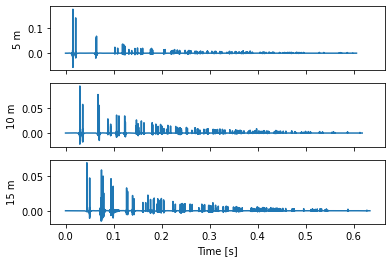

In [10]:
# Cette fonction est montree ici
room.compute_rir()

# plot the RIR between mic 1 and source 0
fig, ax = plt.subplots(3, 1, sharex=True)
for i in range(3):
    sig = room.rir[i][0]
    time = np.linspace(0, dt*(len(sig)), len(sig))
    ax[i].set_ylabel('%0.0d m' %((i+1)*5))
    ax[i].plot(time, sig)
ax[2].set_xlabel('Time [s]');

La figure ci-dessus montre les échos qui frappent un mur puis l'autre. Pour un auditeur, chacun de ces pics est le signal d'entrée. Le phénomène d'échoe est beaucoup plus facile à voir pour un signal court parce qu'on entend qu'un seul signal à la fois. L'échoe n'est donc pas cachée dans le signal d'entrée.

Remarquez que le temps de la RIR est d'environ 0.6 secondes et que la différence de temps entre la fin du signal d'entrée et la fin du signal de sortie est d'environ 0.6 secondes. 

Une pièce plus grande laisse plus de temps entre les echos. En voici un exemple.

c:\users\felix\appdata\local\programs\python\python38\lib\site-packages\pyroomacoustics\room.py:904: UserWarning: The number of rays used for ray tracing is larger than100000 which may result in slow simulation.  The numberof rays was automatically chosen to provide accurateroom impulse response based on the room volume and thereceiver radius around the microphones.  The number ofrays may be reduced by increasing the size of thereceiver.  This tends to happen especially for largerooms with small receivers.  The receiver is a spherearound the microphone and its radius (in meters) may bespecified by providing the `receiver_radius` keywordargument to the `set_ray_tracing` method.
  warnings.warn(


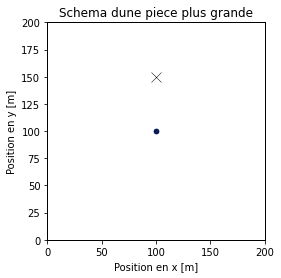

In [11]:
size = np.array([200, 200])
room = pra.ShoeBox(size, materials=m, fs=fs, max_order=10, air_absorption=True, ray_tracing=True)
X_source = 0.5*size
X_micro = X_source + np.array([0, size[1]/4])
room.add_source(X_source, signal=signal)
room.add_microphone(X_micro)

# ici, je change les paramètres par défaut de la simulation pour permettre une simulation plus rapide.
room.set_ray_tracing(receiver_radius=5, n_rays=1000, energy_thres=1e-5)

room.plot(mic_marker_size=100);
plt.title('Schema d''une piece plus grande');
plt.xlabel('Position en x [m]');
plt.ylabel('Position en y [m]');

In [12]:
room.simulate()

# L'auditeur entendrait ce signal.
IPython.display.display(IPython.display.Audio(room.mic_array.signals[0,:], rate=fs))

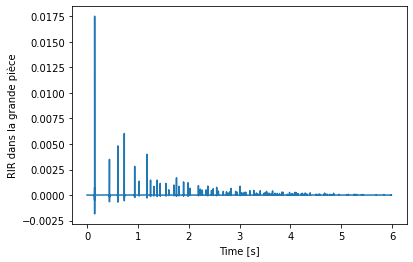

In [13]:
# Et à ce moment, la réponse impulsionelle serait:

sig = room.rir[0][0]
time = np.linspace(0, dt*(len(sig)), len(sig))
plt.ylabel('RIR dans la grande pièce')
plt.plot(time, sig)
plt.xlabel('Time [s]');

Le graphique ci-dessus permet d'apprécier une RIR de la pièce plus longue et avec plus de distance entre chaque pics d'echoes.